In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import interp1d, splprep, splev
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from skimage.transform import radon
from skimage import measure
import svgwrite
from skimage.draw import polygon2mask
from skimage.measure import perimeter, regionprops_table
from skimage.transform import radon
from scipy.fft import fft


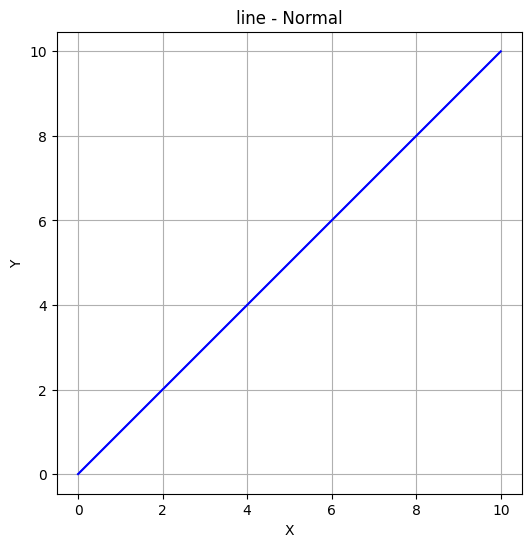

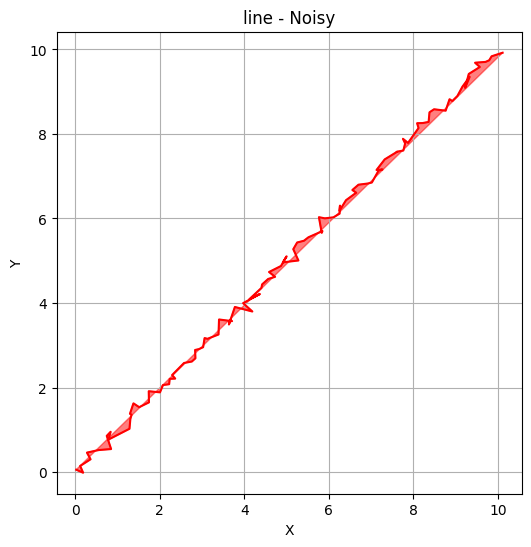

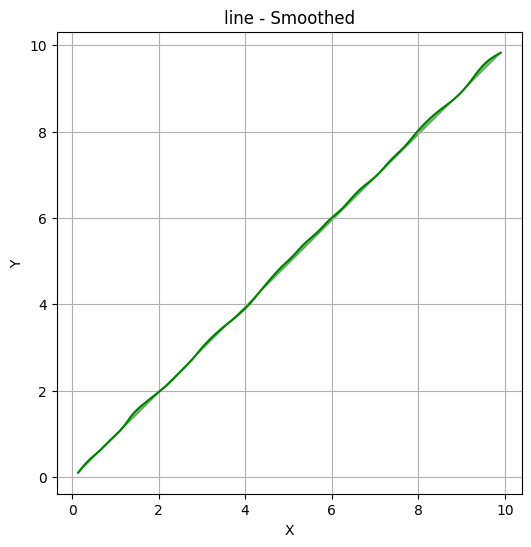

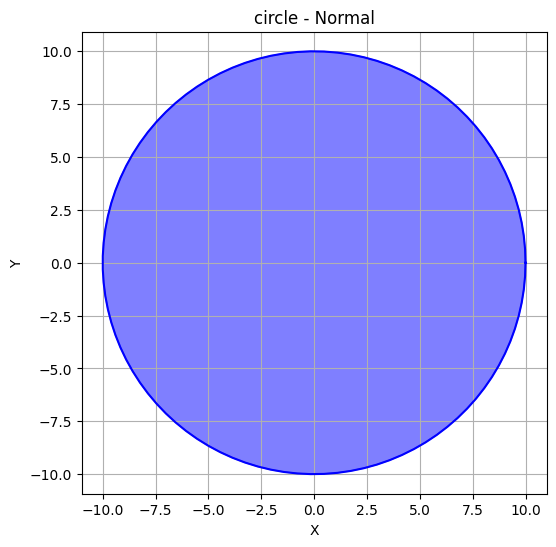

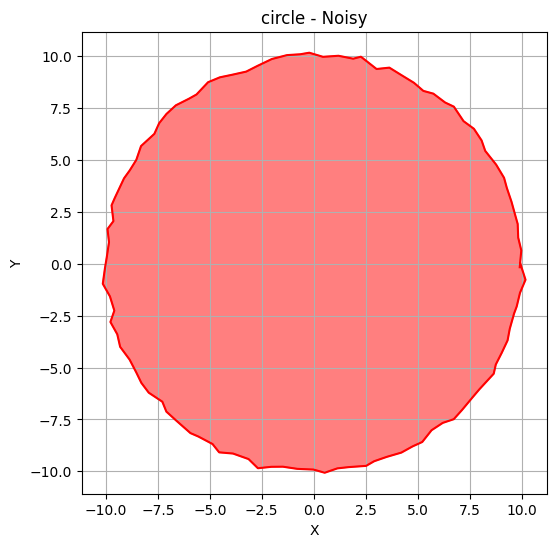

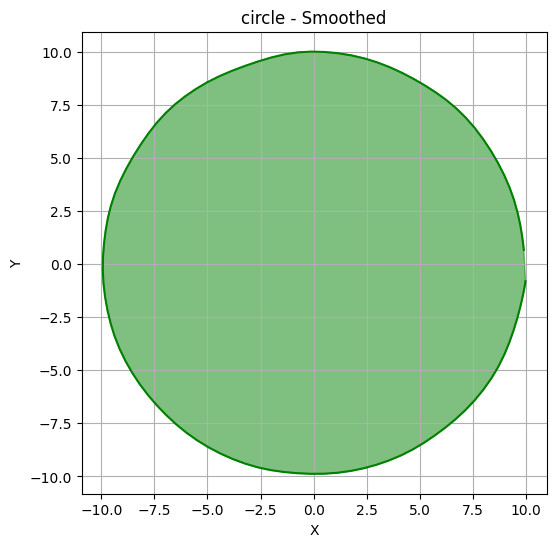

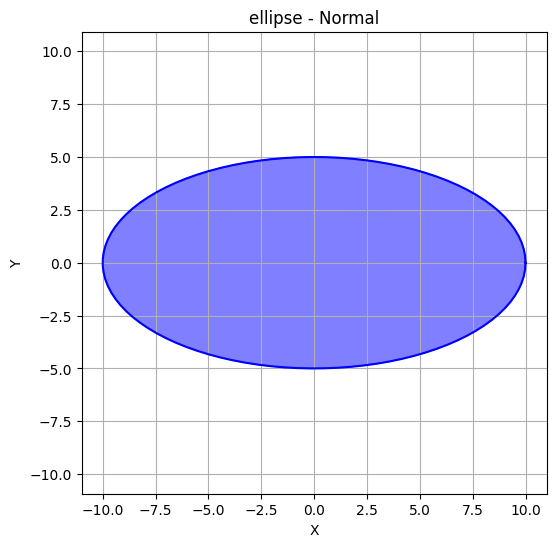

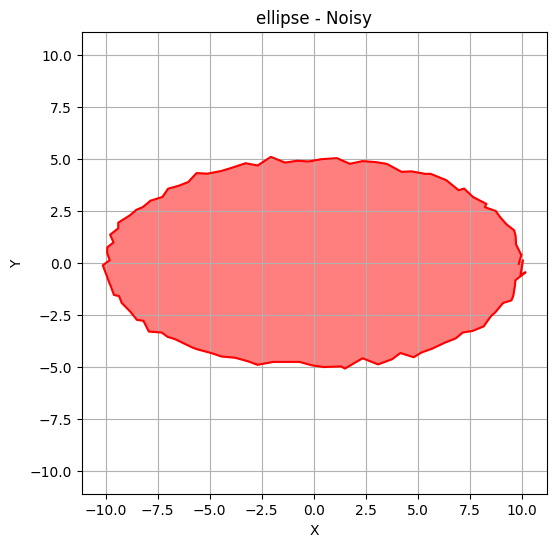

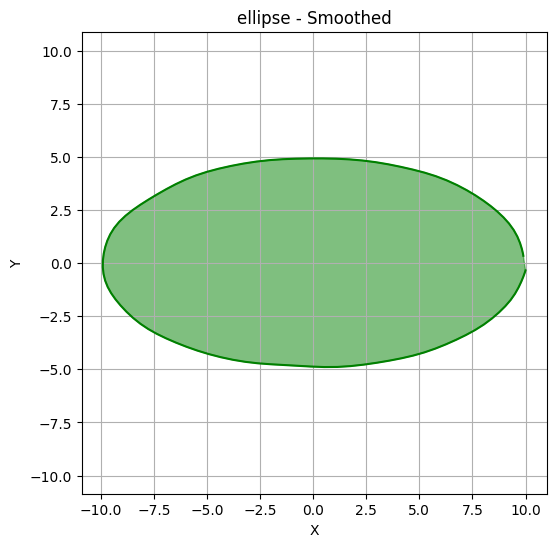

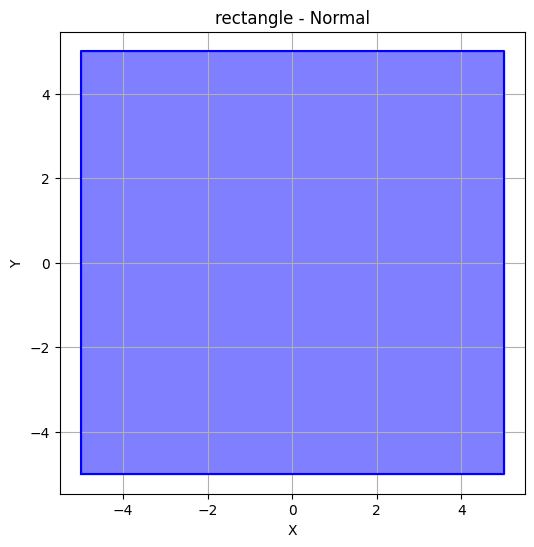

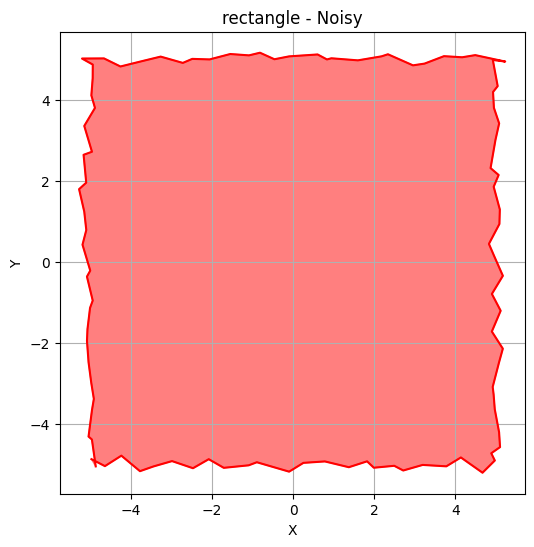

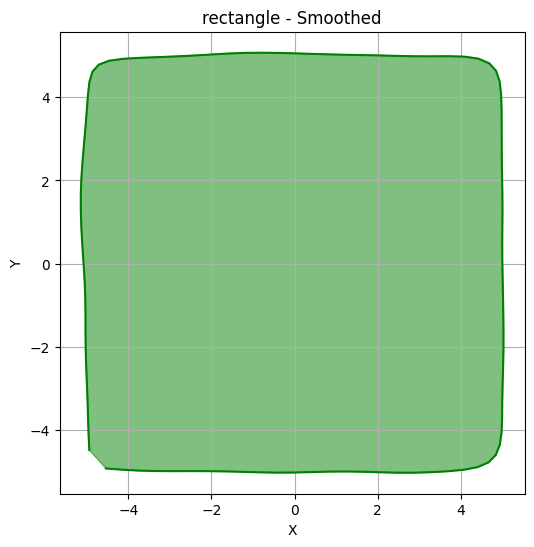

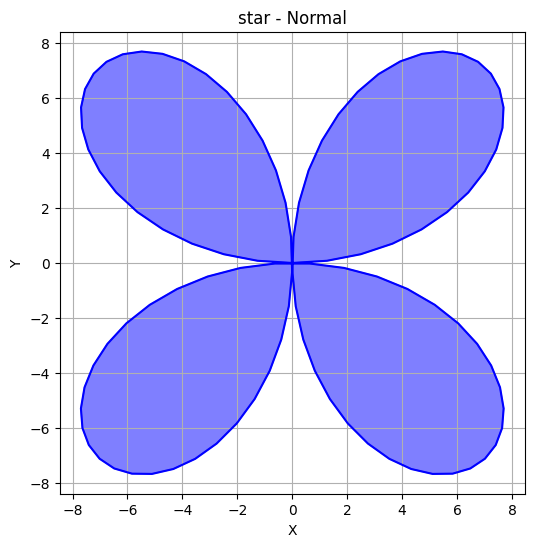

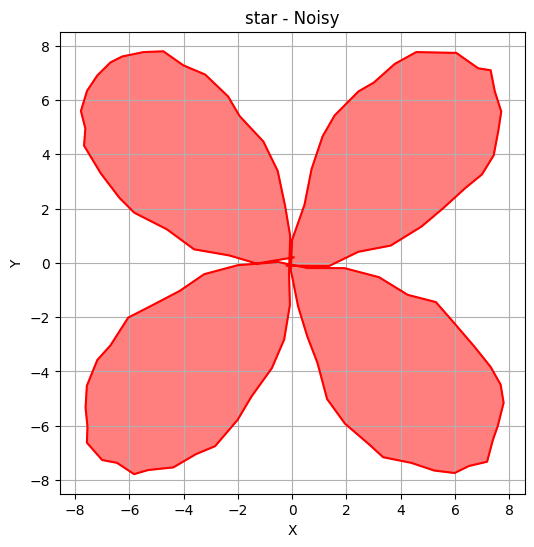

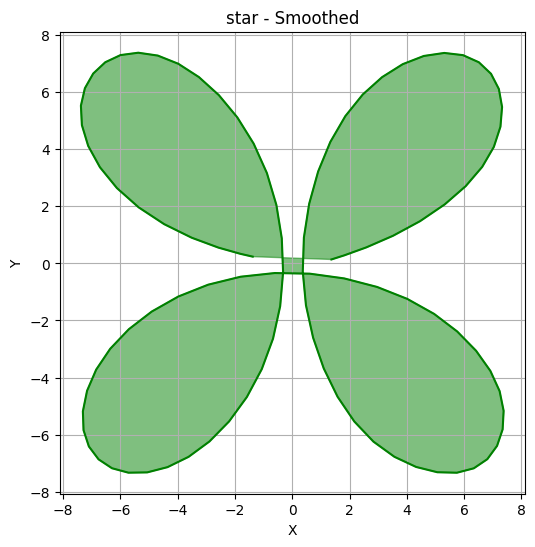

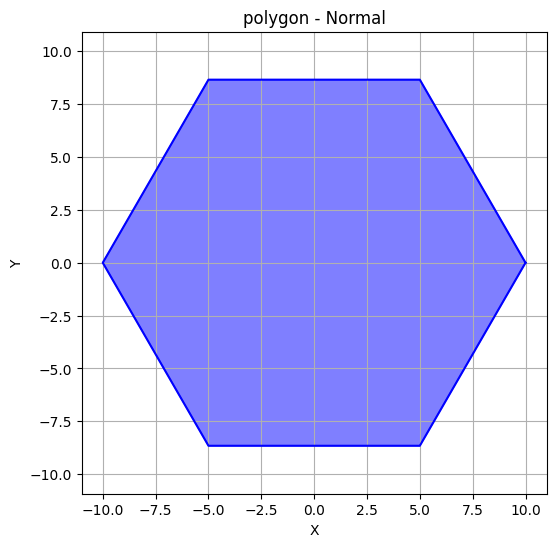

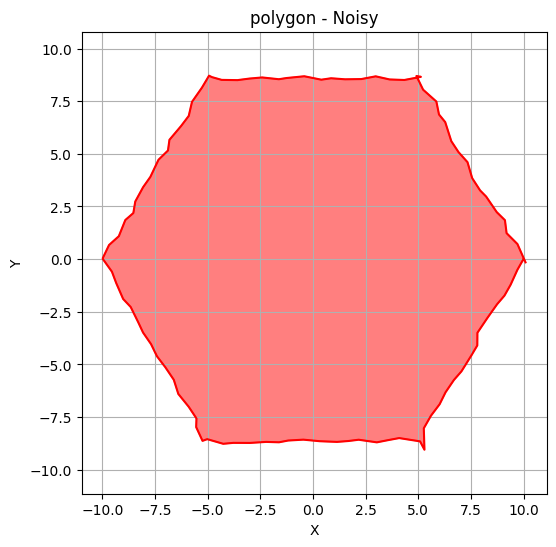

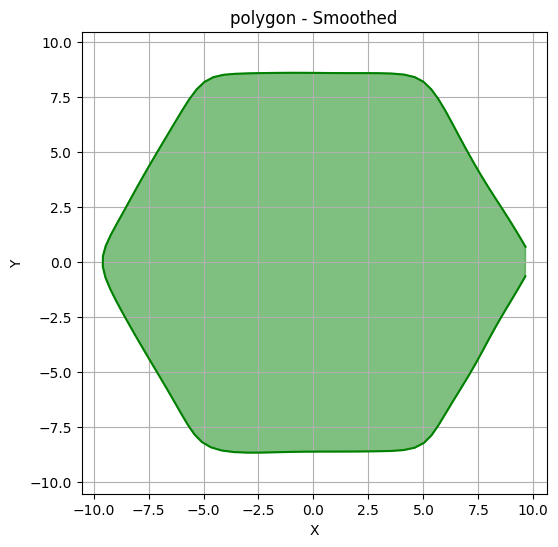

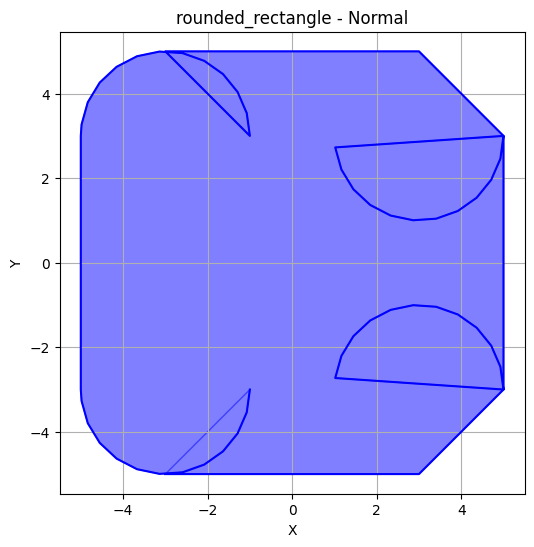

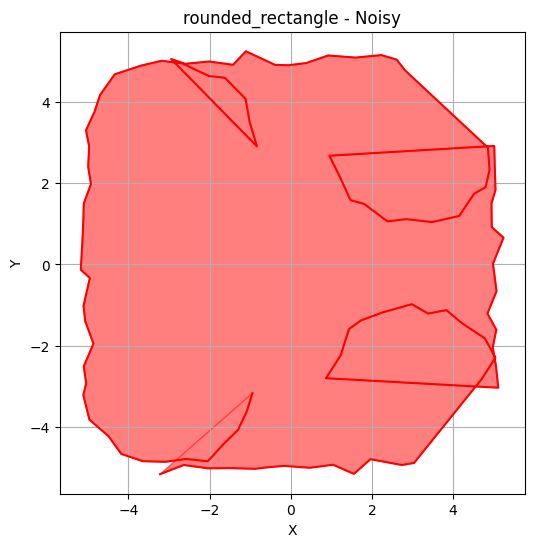

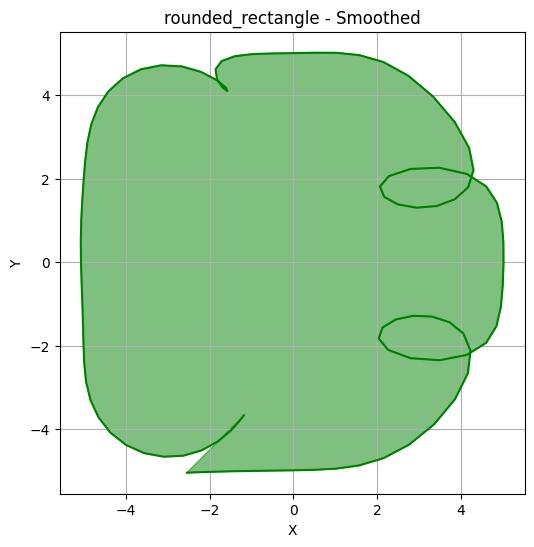

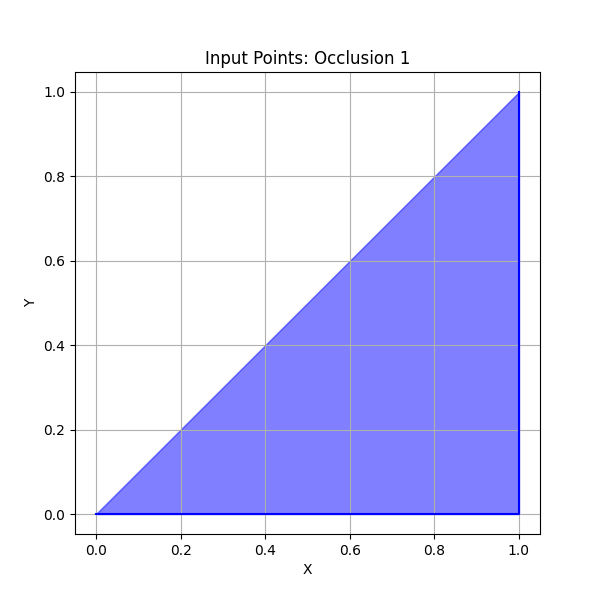

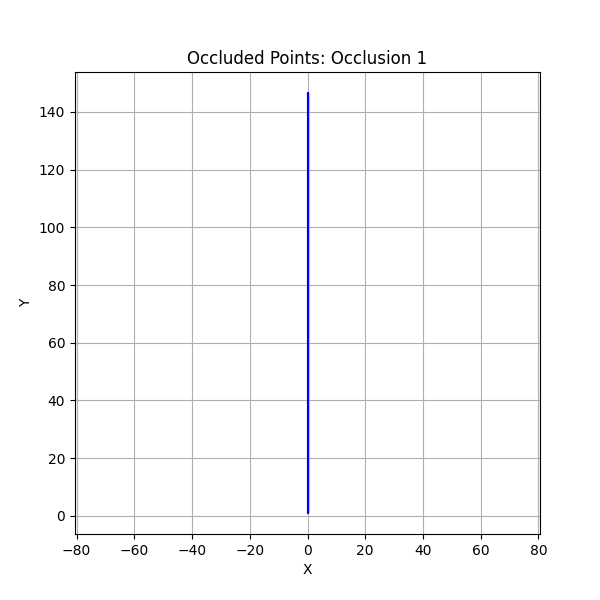

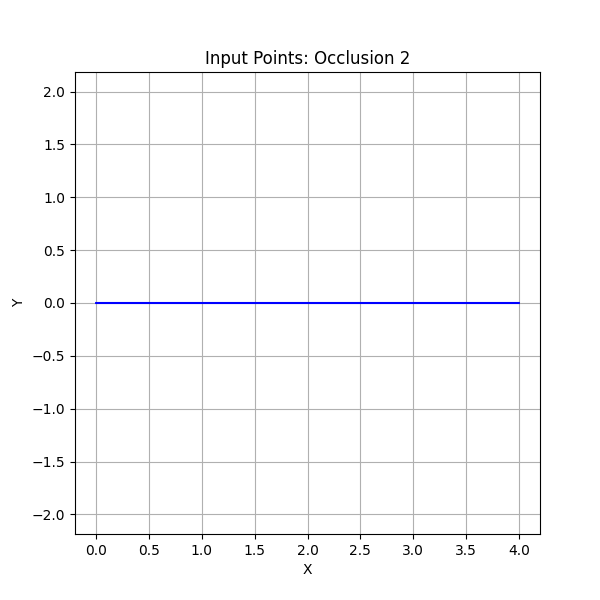

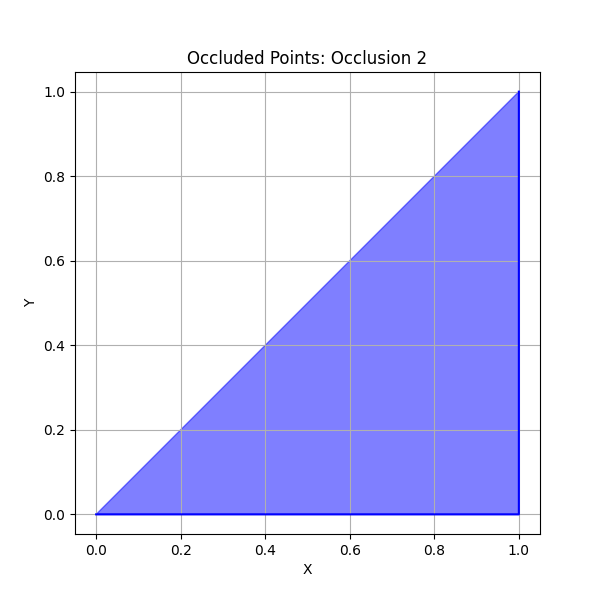

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.spatial.distance import pdist
from scipy.interpolate import splprep, splev
from PIL import Image
from IPython.display import display, Image as IPImage


# Function to generate points for various shapes
def generate_line(start, end, num_points=100):
    x = np.linspace(start[0], end[0], num_points)
    y = np.linspace(start[1], end[1], num_points)
    return np.column_stack((x, y))

def generate_circle(center, radius, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return np.column_stack((x, y))

def generate_ellipse(center, axes, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + axes[0] * np.cos(angles)
    y = center[1] + axes[1] * np.sin(angles)
    return np.column_stack((x, y))

def generate_rectangle(bottom_left, width, height, num_points=100):
    num_points_per_side = num_points // 4
    bottom = np.column_stack((np.linspace(bottom_left[0], bottom_left[0] + width, num_points_per_side), 
                              np.full(num_points_per_side, bottom_left[1])))
    right = np.column_stack((np.full(num_points_per_side, bottom_left[0] + width), 
                             np.linspace(bottom_left[1], bottom_left[1] + height, num_points_per_side)))
    top = np.column_stack((np.linspace(bottom_left[0] + width, bottom_left[0], num_points_per_side), 
                           np.full(num_points_per_side, bottom_left[1] + height)))
    left = np.column_stack((np.full(num_points_per_side, bottom_left[0]), 
                            np.linspace(bottom_left[1] + height, bottom_left[1], num_points_per_side)))
    return np.concatenate([bottom, right, top, left])

def generate_star(center, radius, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.sin(2 * angles) * np.cos(angles)
    y = center[1] + radius * np.sin(2 * angles) * np.sin(angles)
    return np.column_stack((x, y))

def generate_polygon(center, radius, num_sides, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    polygon_points = np.column_stack((x, y))
    polygon = np.concatenate([np.linspace(polygon_points[i], polygon_points[(i+1) % num_sides], num_points // num_sides) 
                               for i in range(num_sides)])
    return polygon

def generate_rounded_rectangle(bottom_left, width, height, radius, num_points=100):
    corner_points = num_points // 8
    straight_points = (num_points - 4 * corner_points) // 4
    
    bottom = np.column_stack((np.linspace(bottom_left[0] + radius, bottom_left[0] + width - radius, straight_points), 
                              np.full(straight_points, bottom_left[1])))
    right = np.column_stack((np.full(straight_points, bottom_left[0] + width), 
                             np.linspace(bottom_left[1] + radius, bottom_left[1] + height - radius, straight_points)))
    top = np.column_stack((np.linspace(bottom_left[0] + width - radius, bottom_left[0] + radius, straight_points), 
                           np.full(straight_points, bottom_left[1] + height)))
    left = np.column_stack((np.full(straight_points, bottom_left[0]), 
                            np.linspace(bottom_left[1] + height - radius, bottom_left[1] + radius, straight_points)))
    
    # Generate the corners as quarter circles
    bottom_left_corner = generate_circle([bottom_left[0] + radius, bottom_left[1] + radius], radius, corner_points * 2)[corner_points:]
    bottom_right_corner = generate_circle([bottom_left[0] + width - radius, bottom_left[1] + radius], radius, corner_points * 2)[:corner_points]
    top_right_corner = generate_circle([bottom_left[0] + width - radius, bottom_left[1] + height - radius], radius, corner_points * 2)[corner_points:]
    top_left_corner = generate_circle([bottom_left[0] + radius, bottom_left[1] + height - radius], radius, corner_points * 2)[:corner_points]
    
    # Concatenate all parts
    rounded_rectangle = np.concatenate([bottom, bottom_right_corner, right, top_right_corner, top, top_left_corner, left, bottom_left_corner])
    
    return rounded_rectangle

def add_noise(points, noise_level=0.1):
    noisy_points = points + np.random.normal(scale=noise_level, size=points.shape)
    return noisy_points

def smooth_curve(points, method='gaussian', **kwargs):
    if method == 'gaussian':
        sigma = kwargs.get('sigma', 2)
        x = points[:, 0]
        y = points[:, 1]
        smoothed_x = gaussian_filter1d(x, sigma=sigma)
        smoothed_y = gaussian_filter1d(y, sigma=sigma)
        return np.column_stack((smoothed_x, smoothed_y))
    
    elif method == 'spline':
        s = kwargs.get('s', 0.5)
        x = points[:, 0]
        y = points[:, 1]
        t = np.arange(len(x))
        spline_x = UnivariateSpline(t, x, s=s)
        spline_y = UnivariateSpline(t, y, s=s)
        smoothed_x = spline_x(t)
        smoothed_y = spline_y(t)
        return np.column_stack((smoothed_x, smoothed_y))
    
    else:
        raise ValueError("Unsupported smoothing method")

def complete_curve(points, num_points=100, method='spline', occlusion_level='fully_contained'):
    unique_points = np.unique(points, axis=0)
    
    if len(unique_points) < 2:
        raise ValueError("Not enough unique points for curve completion.")
    
    x, y = unique_points[:, 0], unique_points[:, 1]
    
    if method == 'linear':
        interp_x = interp1d(np.arange(len(x)), x, kind='linear', fill_value='extrapolate')
        interp_y = interp1d(np.arange(len(y)), y, kind='linear', fill_value='extrapolate')
        new_x = interp_x(np.linspace(0, len(x) - 1, num_points))
        new_y = interp_y(np.linspace(0, len(y) - 1, num_points))

    elif method == 'spline':
        if len(x) < 2:
            raise ValueError("Not enough unique points for spline interpolation.")
        
        pairwise_distances = pdist(unique_points)
        if np.min(pairwise_distances) < 1e-10:
            raise ValueError("Points too close to each other for stable spline interpolation.")
        
        tck, u = splprep([x, y], s=0)
        new_points = splev(np.linspace(0, 1, num_points), tck)
        new_x, new_y = new_points

    elif method == 'bezier':
        bezier_points = np.linspace(0, 1, num_points)
        new_x = np.polynomial.Polynomial.fit(bezier_points, x, deg=min(3, len(x) - 1)).linspace(num_points)[1]
        new_y = np.polynomial.Polynomial.fit(bezier_points, y, deg=min(3, len(y) - 1)).linspace(num_points)[1]

    else:
        raise ValueError("Unsupported completion method")

    if occlusion_level == 'fully_contained':
        return np.column_stack((new_x, new_y))

    elif occlusion_level == 'partially_contained':
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        mask = (new_x >= x_min) & (new_x <= x_max) & (new_y >= y_min) & (new_y <= y_max)
        return np.column_stack((new_x[mask], new_y[mask]))
    elif occlusion_level == 'disconnected':
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        disconnected_points = np.column_stack((new_x, new_y))
        return disconnected_points[(disconnected_points[:, 0] < x_min) | (disconnected_points[:, 0] > x_max) |
                                   (disconnected_points[:, 1] < y_min) | (disconnected_points[:, 1] > y_max)]

    else:
        raise ValueError("Unsupported occlusion level")
def detect_symmetry(points, method='reflection'):
    if method == 'reflection':
        x = points[:, 0]
        y = points[:, 1]
        mid_x = np.mean(x)
        mid_y = np.mean(y)
        reflected_x = 2 * mid_x - x
        reflected_y = 2 * mid_y - y
        reflected_points = np.column_stack((reflected_x, reflected_y))
        return np.all(np.isclose(np.sort(reflected_points, axis=0), np.sort(points, axis=0)))

    elif method == 'rotation':
        x = points[:, 0]
        y = points[:, 1]
        center = np.mean(points, axis=0)
        angle = np.arctan2(y - center[1], x - center[0])
        rotated_x = center[0] + (x - center[0]) * np.cos(angle) - (y - center[1]) * np.sin(angle)
        rotated_y = center[1] + (x - center[0]) * np.sin(angle) + (y - center[1]) * np.cos(angle)
        rotated_points = np.column_stack((rotated_x, rotated_y))
        return np.all(np.isclose(np.sort(rotated_points, axis=0), np.sort(points, axis=0)))
    
    elif method == 'fourier':
        x = points[:, 0]
        y = points[:, 1]
        x_fft = fft(x)
        y_fft = fft(y)
        freq = np.fft.fftfreq(len(x))
        x_freq = np.abs(x_fft)
        y_freq = np.abs(y_fft)
        return np.all(np.isclose(x_freq, y_freq))

    else:
        raise ValueError("Unsupported symmetry detection method")


def generate_shapes():
    shapes = {
        'line': generate_line(start=[0, 0], end=[10, 10]),
        'circle': generate_circle(center=[0, 0], radius=10),
        'ellipse': generate_ellipse(center=[0, 0], axes=[10, 5]),
        'rectangle': generate_rectangle(bottom_left=[-5, -5], width=10, height=10),
        'star': generate_star(center=[0, 0], radius=10),
        'polygon': generate_polygon(center=[0, 0], radius=10, num_sides=6),
        'rounded_rectangle': generate_rounded_rectangle(bottom_left=[-5, -5], width=10, height=10, radius=2)
    }
    return shapes
def plot_and_display(title, points, color='blue'):
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], points[:, 1], color=color)
    plt.fill(points[:, 0], points[:, 1], color=color, alpha=0.5)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def display_shapes():
    shapes = generate_shapes()
    for name, shape in shapes.items():
        noisy_shape = add_noise(shape, noise_level=0.1)
        smoothed_shape = smooth_curve(noisy_shape, method='gaussian', sigma=2)
        
        plot_and_display(f'{name} - Normal', shape, color='blue')
        plot_and_display(f'{name} - Noisy', noisy_shape, color='red')
        plot_and_display(f'{name} - Smoothed', smoothed_shape, color='green')

# Display all shapes in normal, noisy, and smoothened states
display_shapes()
def plot_and_save_image(title, points, filename):
    plt.figure(figsize=(6, 6))
    plt.plot(points[:, 0], points[:, 1], color='blue')
    plt.fill(points[:, 0], points[:, 1], color='blue', alpha=0.5)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

def display_occluded_files(file_paths):
    for file_path, sol_path, label in file_paths:
        try:
            # Load and plot input points
            points = pd.read_csv(file_path, header=None).values
            plot_and_save_image(f'Input Points: {label}', points, f'{label}_input.png')
            display(IPImage(filename=f'{label}_input.png'))

            # Load and plot occluded points
            occluded_points = pd.read_csv(sol_path, header=None).values
            plot_and_save_image(f'Occluded Points: {label}', occluded_points, f'{label}_occluded.png')
            display(IPImage(filename=f'{label}_occluded.png'))
        
        except FileNotFoundError as e:
            print(f"Error: {e}")

# Example usage for occluded files
occluded_files = [
    ("G:/Curvetopiaa/problems/problems/occlusion1.csv", "G:/Curvetopiaa/problems/problems/occlusion1_sol.csv", "Occlusion 1"),
    ("G:/Curvetopiaa/problems/problems/occlusion2.csv", "G:/Curvetopiaa/problems/problems/occlusion2_sol.csv", "Occlusion 2")
]
display_occluded_files(occluded_files)